In [1]:
!nvidia-smi

Fri Jan 24 22:14:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K20Xm         On   | 00000000:08:00.0 Off |                    0 |
| N/A   50C    P0    57W / 235W |    310MiB /  5700MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K20Xm         On   | 00000000:84:00.0 Off |                    0 |
| N/A   54C    P0    57W / 235W |    226MiB /  5700MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
go = False
if go:
    
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
    import tensorflow as tf
    from keras import backend as K

    set_gpu=True

    if set_gpu:
        os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";  # The GPU id to use, usually either "0" or "1";
        os.environ["CUDA_VISIBLE_DEVICES"]="0";  # Do other imports now...
        print(os.environ["CUDA_VISIBLE_DEVICES"])


        num_cores = 39

        GPU=True
        CPU=False

        if GPU:
            num_GPU = 1
            num_CPU = 1
        if CPU:
            num_CPU = 1
            num_GPU = 0

        config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                                inter_op_parallelism_threads=num_cores, 
                                allow_soft_placement=True,
                                device_count = {'CPU' : num_CPU,
                                                'GPU' : num_GPU}
                               )

        session = tf.Session(config=config)
        K.set_session(session)


In [3]:
#!wget https://raw.githubusercontent.com/DBertazioli/host/master/datas/df_final_processed.csv

In [4]:
#!pip install pyforest
#from pyforest import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import keras


df = pd.read_csv("../data/df_final_processed.csv", index_col = 0)
df.head()

from keras.preprocessing.sequence import TimeseriesGenerator

#some zeroes
#series = df.level_scaled.values
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0.01, 1))

series = sc.fit_transform(df.level.values.reshape(-1, 1))

split_index = -7*24

#test_series = series [split_index:]
#series = series [:split_index]
n_features = 1
#series = series.reshape((len(series), n_features))
#test_series = test_series.reshape((len(test_series), n_features))

series.shape


Using TensorFlow backend.
/opt/intel/intelpython3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/intel/intelpython3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/intel/intelpython3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/intel/intelpython3/lib/python3.6/site-packages/t

(78888, 1)

In [5]:
# 24h ahead single preds
steps_ahead = 168-1
padded_series = np.expand_dims(np.concatenate([series.flatten(), np.zeros(steps_ahead)]), axis = -1)
padded_series

target_series = np.roll(padded_series, -steps_ahead)[:series.shape[0]] #need to discard the last as well

In [6]:
target_series = target_series[:-steps_ahead]  #removing the zero padding
series = series[:-steps_ahead] #removing the zero padding

series.shape, target_series.shape

((78721, 1), (78721, 1))

In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, CuDNNLSTM, LeakyReLU, Dropout, BatchNormalization
from keras.utils import multi_gpu_model
from keras import backend as K
from keras.optimizers import Adam 


# define model
def make_model(n_input, n_features, 
               verbose = False, multi = True, use_CuDNNLSTM = True,
              loss = "mse", metrics = ["mae", "mape"], opt = "adam",
              lr = 0.001, batch_size = 512):
    K.clear_session()
    LSTM_layer = LSTM if not use_CuDNNLSTM else CuDNNLSTM
    if opt == "adam":
        opt = Adam (lr = lr )
    else:
        opt = opt
    
    model = Sequential()
    
    model.add(LSTM_layer(1024, input_shape=(n_input, n_features), return_sequences=True))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(rate = 0.4))
    for i in range(1):
        model.add(LSTM_layer(512, return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout( rate = 0.3))
    
    for i in range(1):
        model.add(LSTM_layer(256, return_sequences = False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(rate = 0.2))

    model.add(Dense(128))
    model.add(LeakyReLU())
    model.add(Dropout(rate = 0.1))
    
    model.add(Dense(1))
    
    model.compile(optimizer=opt, loss=loss, metrics = metrics)
    if verbose:
        model.summary()
    if multi:
        mmodel = multi_gpu_model(model, 2)
        mmodel.compile(optimizer=opt, loss=loss, metrics = metrics)
        return mmodel, model
    else: 
        
        return None, model

In [27]:
n_input = 1*12

train_generator = TimeseriesGenerator(series, target_series, start_index=0, end_index=len(series) + split_index-1, length=n_input, batch_size=1)
#val_generator = TimeseriesGenerator(series, target_series, start_index=len(series) + 2*split_index-n_input, end_index=len(series)+split_index-1, length=n_input, batch_size=1)
test_generator = TimeseriesGenerator(series, target_series, start_index=len(series) + split_index -n_input, end_index=len(series)-1, length=n_input, batch_size=1)

In [28]:
len(train_generator), len(test_generator)

(78541, 168)

In [29]:
train_list = []
test_list = []
for train,test in train_generator:
    train_list.append(train)
    test_list.append(test)
train_input = np.concatenate(train_list, axis = 0)
train_targets = np.concatenate(test_list, axis = 0)
train_input.shape, train_targets.shape

((78541, 12, 1), (78541, 1))

In [30]:
train_list = []
test_list = []
for train, test in test_generator: #some weird but with the last access
    train_list.append(train)
    test_list.append(test)

    
test_input = np.concatenate(train_list, axis = 0)
test_targets = np.concatenate(test_list, axis = 0)
test_input.shape, test_targets.shape

((168, 12, 1), (168, 1))

In [31]:
import wandb
wandb.login()


True

In [32]:
from wandb.keras import WandbCallback as wb

wandb.init(project = "venice_is_drowing", name = f"lstm_single_output_test_168h_{n_input}_input")
cfg = wandb.config
batch_size = 512
cfg.batch_size = batch_size
cfg.n_features = n_features
cfg.n_input = n_input
cfg.epochs = 250

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [33]:
mmodel, model = make_model(n_input, n_features, opt = "adam", lr = 0.001,
                           multi = True, use_CuDNNLSTM = True, verbose = True,
                           loss = "mape", metrics = ["mse","mae", "mape"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 12, 1024)          4206592   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 1024)          4096      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12, 1024)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 1024)          0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 12, 512)           3149824   
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 512)           2048      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12, 512)           0         
__________

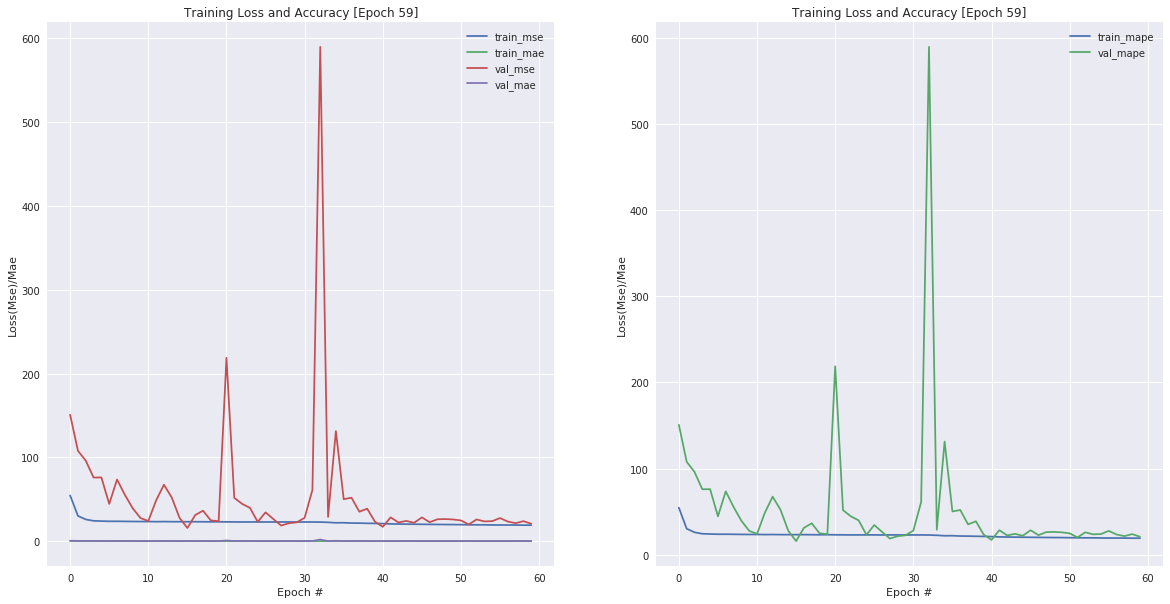

Epoch 61/250
78541/78541 [==============================] - 20s 250us/step - loss: 18.9713 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0810 - mean_absolute_percentage_error: 18.9713 - val_loss: 23.3025 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0675 - val_mean_absolute_percentage_error: 23.3025
Epoch 62/250
78541/78541 [==============================] - 20s 250us/step - loss: 18.9085 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0808 - mean_absolute_percentage_error: 18.9085 - val_loss: 25.7690 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0728 - val_mean_absolute_percentage_error: 25.7690
Epoch 63/250
78541/78541 [==============================] - 20s 250us/step - loss: 18.8148 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0804 - mean_absolute_percentage_error: 18.8148 - val_loss: 22.5096 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0647 - val_mean_absolute_percentage_error: 22.5096
Epoch 64/250
78541/78541 

In [34]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from myutils import TrainingPlot


plot_losses = TrainingPlot()
es = EarlyStopping(monitor = "val_loss", patience = 50, restore_best_weights = True, verbose = 1)
rl = ReduceLROnPlateau(monitor = "val_loss", patience = 25, cooldown=10, factor=0.5, verbose = 1)

# fit model
history = mmodel.fit(
    train_input, train_targets,
    epochs=cfg.epochs,
    batch_size = cfg.batch_size, 
    
    verbose=1, 
    shuffle = False,
    
    #validation_data=ttest_generator, 
    #validation_steps = 6,
    validation_data = (test_input, test_targets),
    
    callbacks=[plot_losses, 
              es, rl,
              wb(log_gradients=False, log_weights=False)
              ]
)

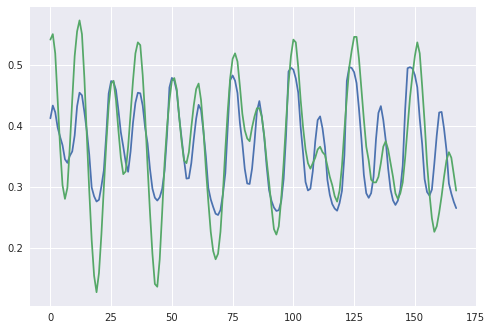

In [35]:
plt.plot(model.predict(test_input))
plt.plot(test_targets)

In [ ]:
model.save("lstm_mape_single_output_168_input_168_step_ahead_y_10_18.h5")

In [36]:
model.evaluate(test_input,test_targets)

168/168 [==============================] - 0s 3ms/step


[15.684960319882347,
 0.003763981873080844,
 0.04866599291563034,
 15.684960319882347]

In [56]:
def iterate_prediction(input_seq = series[-n_input+split_index:split_index], pred_len = 168):
    init_test_arr = np.expand_dims(input_seq, axis = 0)
    preds = []
    for i in range(pred_len):
        pred = model.predict()[0][0]
        preds.append(pred)
        else:
            test_features = np.squeeze(np.squeeze(init_test_arr, axis = -1), axis = 0).tolist()
            pred = model.predict(init_test_arr)[0][0]
            preds.append(pred)
            test_features.append(pred)
            init_test_arr = np.atleast_3d(test_features[-n_input:])

    return np.array(preds)

preds = iterate_prediction()



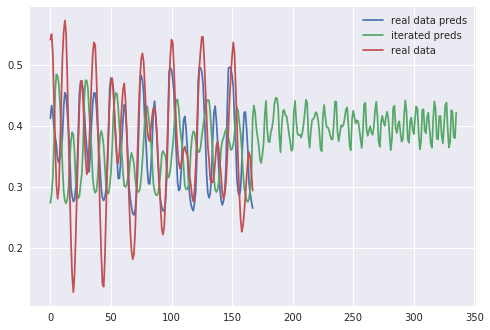

In [53]:
real_preds = model.predict(test_input).flatten()
real_data = series[split_index:].flatten()
real_data = test_targets.flatten()

def plot_preds(real_preds, real_data, preds):
    plt.plot(real_preds, label = "real data preds")
    plt.plot(preds, label = "iterated preds")
    plt.plot(real_data, label = "real data")
    plt.legend()
    plt.show()

plot_preds(real_preds, real_data, preds)

In [ ]:
real_data[0:10],preds[0:10]

In [ ]:
preds.shape, real

In [67]:
def calc_mape(real, pred):
    return (100*np.abs(real-pred)/real/real.shape[0]).sum()
print(calc_mape(real_data, real_preds)) #mape on real-data preds
#print(calc_mape(real_data, preds)) #mape on iterated preds #not really makes sense with 168 steps ahead
print(calc_mape(real_data[0:1], real_preds[0:1]))

15.684960181621706
10.193277160506431
